In [46]:
# TO DO:
# 1. create function to calculate road density done
# 2. create function that will get tile bounds done
# 3. create function that will calculate tile area done
# 4. create function that will calculate ratio denisty/area done
# 5. create function that will calculate rectangle coordinates
# 6. create function that will plot both city bounds and the coordinates

In [49]:
using Luxor
using Colors
using Plots
using IterTools
using DataFrames
using OpenStreetMapX
using LightOSM
using KernelDensity
using Parsers
using Downloads
using OSMToolset
include("kernel_density.jl")
include("distance.jl")
include("prepare_data.jl")
include("analyse.jl")
include("plots.jl")

plot_attractiveness_of_sectors_prcnt (generic function with 1 method)

In [76]:
function calc_tile_road_length(city_parse_data,city_centre)
    road_types = ["motorway", "trunk", "primary", "secondary", 
                "tertiary", "residential", "service", "living_street", 
                "motorway_link", "trunk_link", "primary_link", "secondary_link", 
                "tertiary_link"]
    
    total_length = 0.0
    
    for way in city_parse_data.ways
        if haskey(way.tags, "highway") && (way.tags["highway"] in road_types)
            for i in 1:(length(way.nodes) - 1)
                node1 = ENU(city_parse_data.nodes[way.nodes[i]],city_centre)
                node2 = ENU(city_parse_data.nodes[way.nodes[i + 1]],city_centre)
                total_length += OpenStreetMapX.distance(node1,node2)
            end
        end
    end
    return total_length
end

calc_tile_road_length (generic function with 1 method)

In [77]:
function calc_tile_area(bounds,tile_centre)
    node1 = ENU(bounds,tile_centre)
    return node1.min_x*2*node1.min_y*2
end

calc_tile_area (generic function with 1 method)

In [185]:
"""
y - lat/east
x - lon/north
"""
function rectangle(bounds, centre)
    ENU_coords = ENU(bounds,centre)
    #return [ENU_coords.min_x, ENU_coords.min_x,
    #        ENU_coords.max_x, ENU_coords.max_x],
    #        [ENU_coords.min_y, ENU_coords.max_y,
    #        ENU_coords.max_x, ENU_coords.min_y]
    return [ENU_coords.min_y, ENU_coords.min_y,
            ENU_coords.max_y, ENU_coords.max_y],
            [ENU_coords.min_x, ENU_coords.max_x,
            ENU_coords.max_x, ENU_coords.min_x]
end

rectangle

In [186]:
function get_city_bounds(city_name)
    boundaries_file = string(city_name,"_boundaries.osm")
    admin_city_centre = get_city_centre(boundaries_file)
    city_boundaries = extract_points_ENU(boundaries_file,admin_city_centre)
    return city_boundaries, admin_city_centre
end

get_city_bounds (generic function with 2 methods)

In [147]:
outfiles = tile_osm_file("Kielce.osm",nrow=2,ncol=2,out_dir="./tiles",cache)

MethodError: MethodError: no method matching tile_osm_file(::String, ::typeof(cache); nrow::Int64, ncol::Int64, out_dir::String)

Closest candidates are:
  tile_osm_file(::AbstractString, !Matched::OSMToolset.Bounds; nrow, ncol, out_dir)
   @ OSMToolset ~/.julia/packages/OSMToolset/s0jwL/src/tile.jl:175
  tile_osm_file(::AbstractString; ...)
   @ OSMToolset ~/.julia/packages/OSMToolset/s0jwL/src/tile.jl:175
  tile_osm_file(::AbstractString, !Matched::Float64, !Matched::Float64, !Matched::OSMToolset.Bounds; out_dir) got unsupported keyword arguments "nrow", "ncol"
   @ OSMToolset ~/.julia/packages/OSMToolset/s0jwL/src/tile.jl:158
  ...


In [187]:
dir = "tiles/"
files = readdir(dir)
bounds = []
lengths = []
areas = []
xs = []
ys = []

Any[]

In [188]:
boundaries, admin_city_centre = get_city_bounds("Kielce")
for elem in files
    file = joinpath(dir,elem)
    city_parse = OpenStreetMapX.parseOSM(file)
    mapp = create_map(file; use_cache = false)
    city_centre = OpenStreetMapX.center(mapp.bounds)
    push!(bounds,mapp.bounds)
    push!(lengths, calc_tile_road_length(city_parse,city_centre))
    push!(areas, calc_tile_area(mapp.bounds,city_centre))
    x,y = rectangle(mapp.bounds,admin_city_centre)
    push!(xs,x)
    push!(ys,y)    
end

In [105]:
#lengths./areas

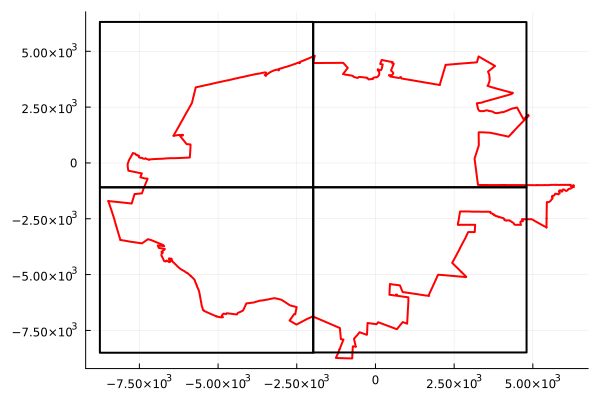

In [202]:
figure = Plots.plot()
grouped_ways = DataFrames.groupby(boundaries, :wayid)
for (key, way) in pairs(grouped_ways)
    Plots.plot!(figure, way.x, way.y, label="wayid $(key)", 
                                    line=:path,legend=false,linecolor=:red,
                                    linewidth=2)
end
for (x,y) in zip(xs,ys)
    Plots.plot!(figure, x, y, seriestype = :shape, lw = 2, fillalpha = 0, linecolor = :black, legend = false)
end
figure